In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
npypath = '/data/asim/ISP/HDR_transformer/data/RAW/2022-0708-1630-2434.npz'
imdata = np.load(npypath)

sht = imdata['sht']
mid = imdata['mid']
lng = imdata['lng']
hdr = imdata['hdr']
sht.shape

(8, 1728, 2304)

In [20]:
# Compare original and luminance-aligned
is_equal = np.all(mid[:4] == mid[4:])

print("Are all 'sht' original and aligned data equal?:", is_equal)


Are all 'sht' original and aligned data equal?: False


In [25]:
ratios = []

for i in range(4):
    num = lng[i]
    denom = lng[4 + i]

    # Avoid division by zero
    valid_mask = denom > 1e-6
    print(num[valid_mask] / denom[valid_mask])
    ratio_est = np.median(num[valid_mask] / denom[valid_mask])
    ratios.append(ratio_est)
    print(f"Estimated exposure ratio for frame {i}: {ratio_est}")


[16. 16. 16. ... 16. 16. 16.]
Estimated exposure ratio for frame 0: 16.0
[16. 16. 16. ... 16. 16. 16.]
Estimated exposure ratio for frame 1: 16.0
[16. 16. 16. ... 16. 16. 16.]
Estimated exposure ratio for frame 2: 16.0
[16. 16. 16. ... 16. 16. 16.]
Estimated exposure ratio for frame 3: 16.0


In [26]:

def bayer_to_rgb(bayer_array):
    H, W = bayer_array.shape[1:]
    bayer = np.zeros((H * 2, W * 2), dtype=bayer_array.dtype)
    bayer[0::2, 0::2] = bayer_array[0]
    bayer[0::2, 1::2] = bayer_array[1]
    bayer[1::2, 0::2] = bayer_array[2]
    bayer[1::2, 1::2] = bayer_array[3]

    bayer = np.clip(bayer, 0, 1)
    bayer = (bayer * 65535).astype(np.uint16)

    #print("Max value before demosaicing:", np.max(bayer))

    rgb = cv2.cvtColor(bayer, cv2.COLOR_BayerBG2RGB)

    rgb = rgb.astype(np.float32) / 65535.0

    #print("Max RGB value after demosaicing:", np.max(rgb))

    # --- Normalize to maximum brightness ---
    if np.max(rgb) > 0:
        rgb = rgb / np.max(rgb)

    # Optional: Apply gamma correction (makes image bright and natural)
    rgb = np.clip(rgb, 0, 1) ** (1/2.2)

    return rgb



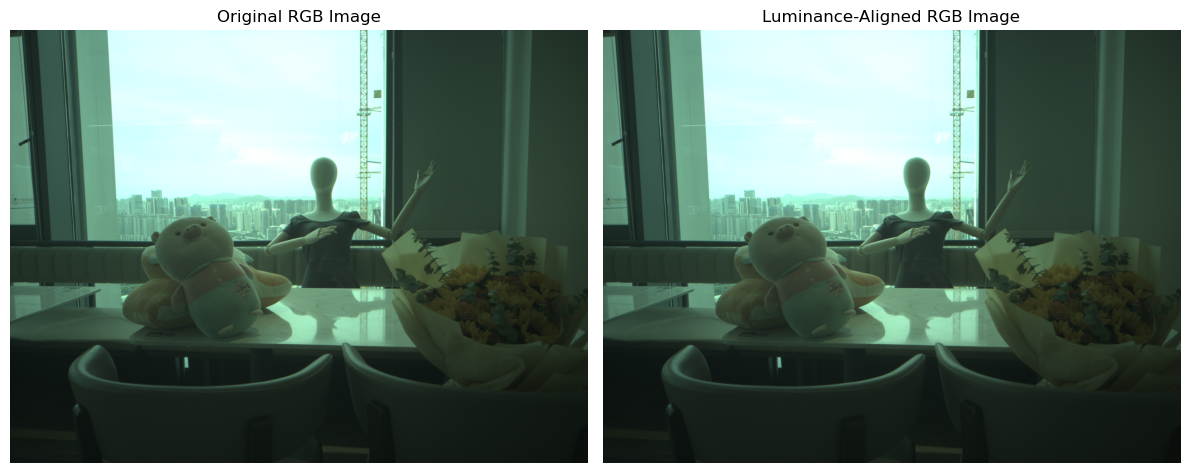

In [29]:
sht_orginal = bayer_to_rgb(mid[:4])
sht_lumi_aligned = bayer_to_rgb(mid[4:])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original images (using the first one as an example)
axes[0].imshow(sht_orginal)  # Show first original RGB image
axes[0].set_title('Original RGB Image')
axes[0].axis('off')  # Hide axes

# Plot luminance-aligned images (using the first one as an example)
axes[1].imshow(sht_lumi_aligned)  # Show first aligned RGB image
axes[1].set_title('Luminance-Aligned RGB Image')
axes[1].axis('off')  # Hide axes

plt.tight_layout()
plt.show()